In [1]:
# ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air')

# Verify you're in the right place
!pwd
!ls -la

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Pintu-Air
total 24843
-rw------- 1 root root 5517847 Jun 11 14:58 '01 Result Data Cleaning Part 1.csv'
-rw------- 1 root root 1964974 Jun 11 14:58 '02 Data Preperation.ipynb'
-rw------- 1 root root  256098 Jun 11 14:58 '02 X_test.csv'
-rw------- 1 root root 4831129 Jun 11 14:58 '02 X_train.csv'
-rw------- 1 root root   40580 Jun 11 14:58 '02 y_test.csv'
-rw------- 1 root root  770651 Jun 11 14:58 '02 y_train.csv'
-rw------- 1 root root  322748 Jun 11 14:58 '03 ARIMA.ipynb'
-rw------- 1 root root    2277 Jun 11 14:58  03_Result_ARIMA.csv
-rw------- 1 root root 6247212 Jun 11 14:58  04c_ARIMA_Manggarai.ipynb
-rw------- 1 root root  631448 Jun 11 14:58  06_DataPreperation_ML.ipynb
-rw------- 1 root root 1611961 Jun 11 14:58  07a_best_model.keras
-rw------- 1 root root  371715 Jun 11 14:58  07a_LSTM_Manggarai.ipynb
-rw------- 1 root root 1685693 Jun 11 14:58  07b_best_model.keras
-rw------- 1 root root  368771 Jun 11 14:58  07b_LSTM_M

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set style and random seed
plt.style.use('default')
np.random.seed(42)

In [4]:
X_train = pd.read_csv('02 X_train.csv', index_col='Tanggal', parse_dates=True)
X_test = pd.read_csv('02 X_test.csv', index_col='Tanggal', parse_dates=True)
y_train = pd.read_csv('02 y_train.csv', index_col='Tanggal', parse_dates=True).squeeze()
y_test = pd.read_csv('02 y_test.csv', index_col='Tanggal', parse_dates=True).squeeze()

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\ny_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nFeatures: {list(X_train.columns)}")


X_train shape: (29640, 30)
X_test shape: (1560, 30)

y_train shape: (29640,)
y_test shape: (1560,)

Features: ['time_index', 'hour_sin', 'hour_cos', 'manggarai_air_lag1', 'manggarai_air_lag2', 'manggarai_air_lag3', 'manggarai_air_lag4', 'manggarai_air_lag5', 'manggarai_air_lag6', 'depok_air_lag6', 'depok_air_lag7', 'depok_air_lag8', 'depok_air_lag9', 'katulampa_air_lag11', 'katulampa_air_lag12', 'katulampa_air_lag13', 'manggarai_cuaca_hujan', 'manggarai_cuaca_lag1_hujan', 'manggarai_cuaca_lag2_hujan', 'manggarai_cuaca_lag3_hujan', 'manggarai_cuaca_lag4_hujan', 'manggarai_cuaca_lag5_hujan', 'manggarai_cuaca_lag6_hujan', 'depok_cuaca_lag6_hujan', 'depok_cuaca_lag7_hujan', 'depok_cuaca_lag8_hujan', 'depok_cuaca_lag9_hujan', 'katulampa_cuaca_lag11_hujan', 'katulampa_cuaca_lag12_hujan', 'katulampa_cuaca_lag13_hujan']


# Model Configuration

In [5]:
# XGBoost parameters optimized for time series and GPU
xgb_params = {
    # GPU Configuration (comment out if GPU not available)
    'tree_method': 'gpu_hist',
    'gpu_id': 0,

    # Core XGBoost parameters
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    # Tree parameters
    'max_depth': 6,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,

    # Learning parameters
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,

    # Regularization
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,

    # Other parameters
    'random_state': 42,
    'n_jobs': -1,# Use all CPU cores for preprocessing
    'verbosity': 1 # Print progress
}

for key, value in xgb_params.items():
    print(f"  {key}: {value}")

  tree_method: gpu_hist
  gpu_id: 0
  objective: reg:squarederror
  eval_metric: rmse
  max_depth: 6
  min_child_weight: 3
  subsample: 0.8
  colsample_bytree: 0.8
  colsample_bylevel: 0.8
  learning_rate: 0.1
  n_estimators: 1000
  early_stopping_rounds: 50
  reg_alpha: 0.1
  reg_lambda: 1.0
  random_state: 42
  n_jobs: -1
  verbosity: 1


In [6]:
start_time = datetime.now()

# Create XGBoost regressor
model = xgb.XGBRegressor(**xgb_params)

# Train
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

training_time = datetime.now() - start_time

print(f"\nTraining completed in: {training_time}")
print(f"Best iteration: {model.best_iteration}")
print(f"Best score: {model.best_score:.4f}")

[0]	validation_0-rmse:39.89020
[76]	validation_0-rmse:24.44320

Training completed in: 0:00:00.826444
Best iteration: 27
Best score: 24.1459


In [7]:
# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate metrics for training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)

# Calculate metrics for test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)

print("TRAINING SET METRICS:")
print(f"  RMSE: {train_rmse:.4f} cm")
print(f"  MAE:  {train_mae:.4f} cm")
print(f"  R²:   {train_r2:.4f}")
print(f"  MAPE: {train_mape:.2f}%")

print("\nTEST SET METRICS:")
print(f"  RMSE: {test_rmse:.4f} cm")
print(f"  MAE:  {test_mae:.4f} cm")
print(f"  R²:   {test_r2:.4f}")
print(f"  MAPE: {test_mape:.2f}%")

TRAINING SET METRICS:
  RMSE: 15.4177 cm
  MAE:  4.5836 cm
  R²:   0.8846
  MAPE: 0.02%

TEST SET METRICS:
  RMSE: 24.1459 cm
  MAE:  5.7199 cm
  R²:   0.3033
  MAPE: 0.02%


In [8]:
# Calculate additional metrics
residuals_test = y_test - test_pred
print(f"\nADDITIONAL TEST METRICS:")
print(f"  Mean Residual: {np.mean(residuals_test):.4f} cm")
print(f"  Std Residual:  {np.std(residuals_test):.4f} cm")
print(f"  Max Error:     {np.max(np.abs(residuals_test)):.4f} cm")


ADDITIONAL TEST METRICS:
  Mean Residual: 2.5441 cm
  Std Residual:  24.0115 cm
  Max Error:     597.6057 cm


Most Important Features:
                    feature  importance
         manggarai_air_lag1    0.328790
         manggarai_air_lag2    0.319166
         manggarai_air_lag4    0.121913
             depok_air_lag8    0.044016
             depok_air_lag7    0.013756
 manggarai_cuaca_lag5_hujan    0.013725
             depok_air_lag6    0.013303
 manggarai_cuaca_lag4_hujan    0.012551
         manggarai_air_lag3    0.010143
     depok_cuaca_lag6_hujan    0.008743
katulampa_cuaca_lag11_hujan    0.008488
katulampa_cuaca_lag13_hujan    0.008407
                   hour_sin    0.007992
                   hour_cos    0.007968
         manggarai_air_lag5    0.007658
        katulampa_air_lag13    0.007354
             depok_air_lag9    0.006898
        katulampa_air_lag12    0.006825
 manggarai_cuaca_lag6_hujan    0.006795
     depok_cuaca_lag7_hujan    0.006352
 manggarai_cuaca_lag1_hujan    0.006045
     depok_cuaca_lag9_hujan    0.005817
                 time_index    0.005149
        katulam

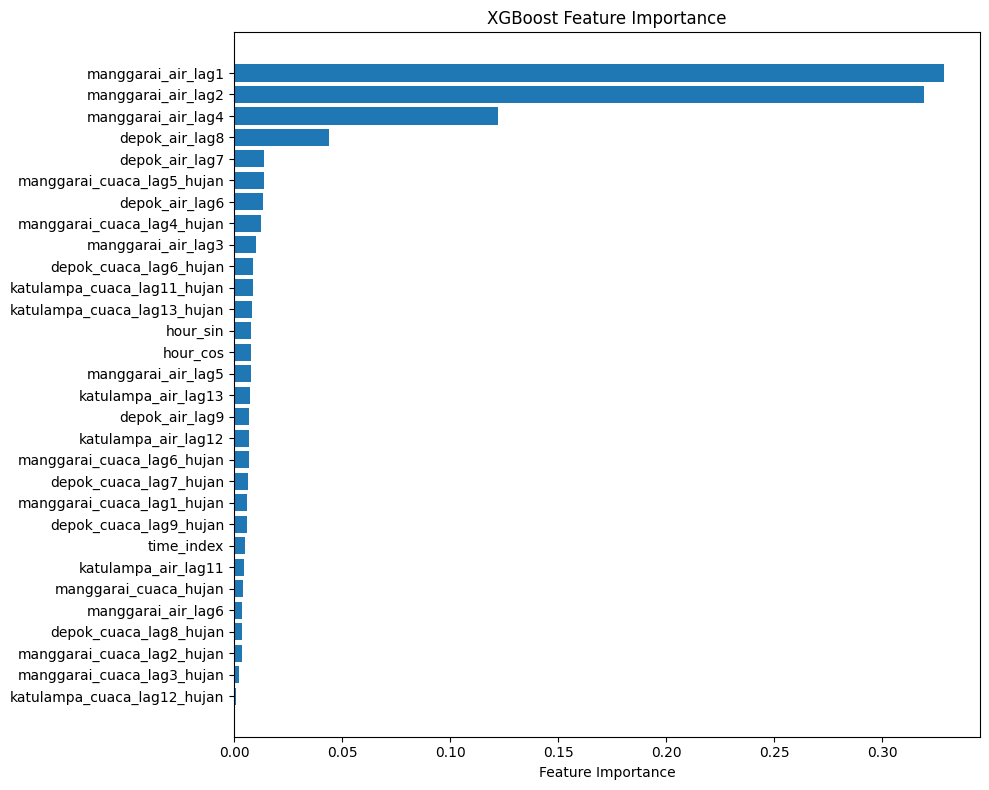

In [9]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Most Important Features:")
print(feature_importance.to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

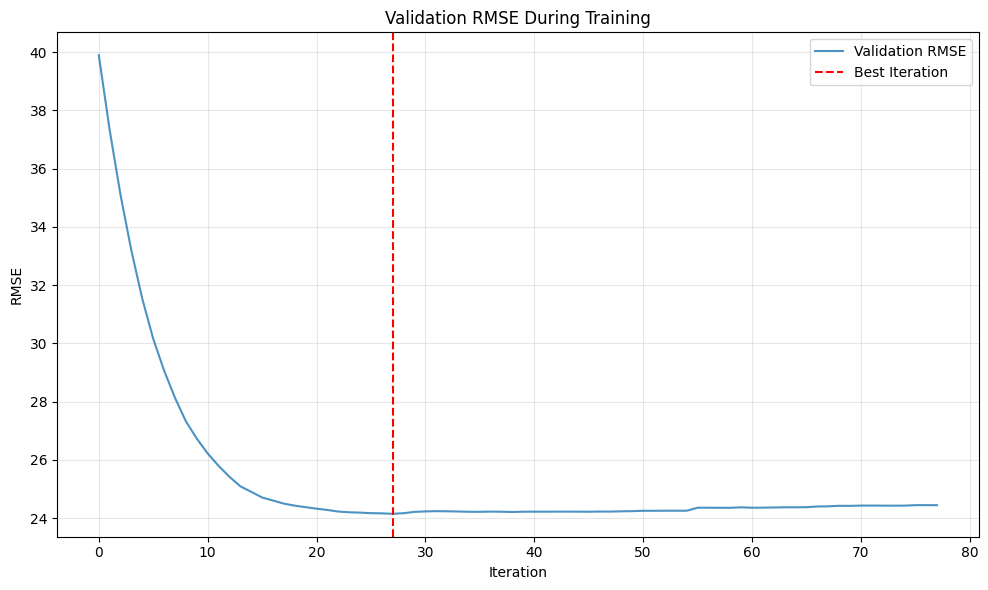

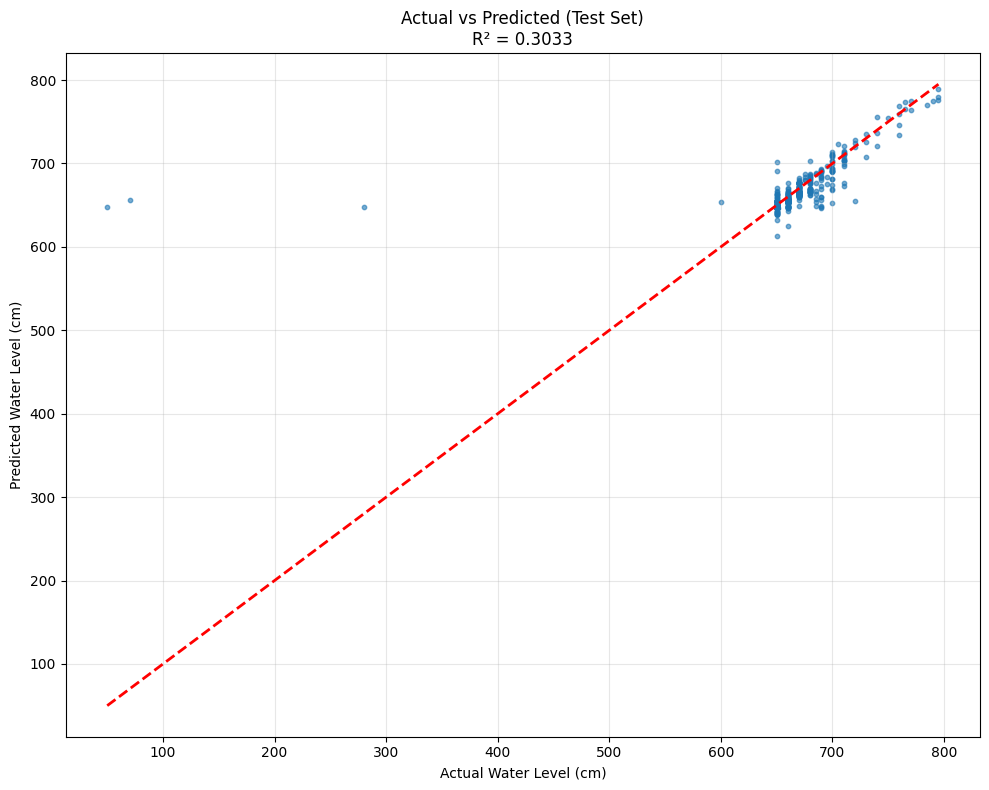

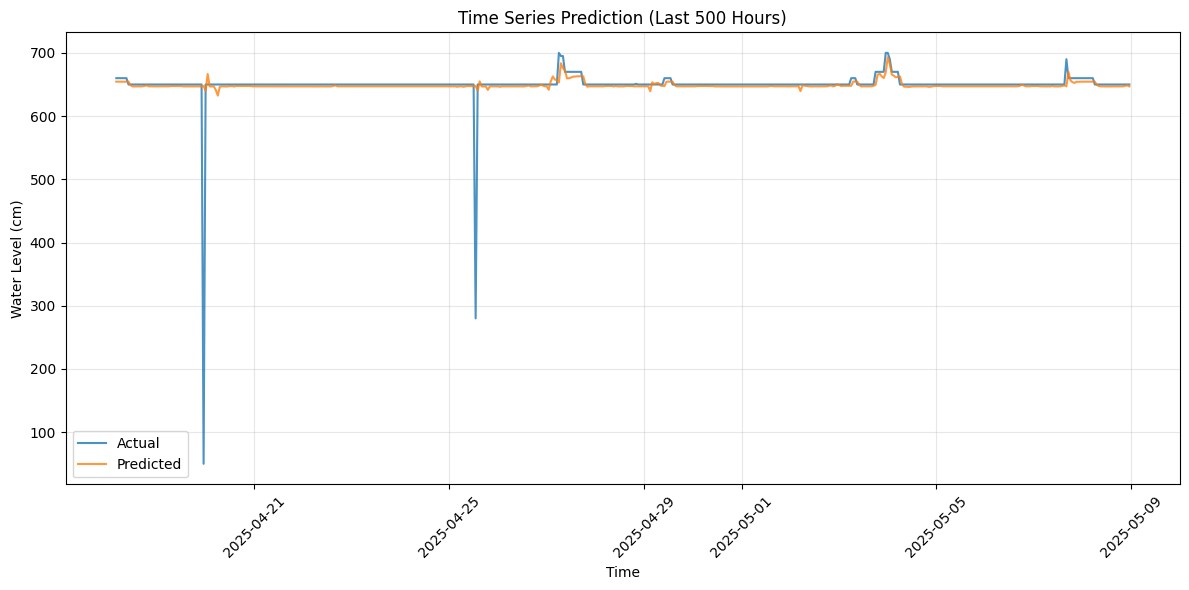

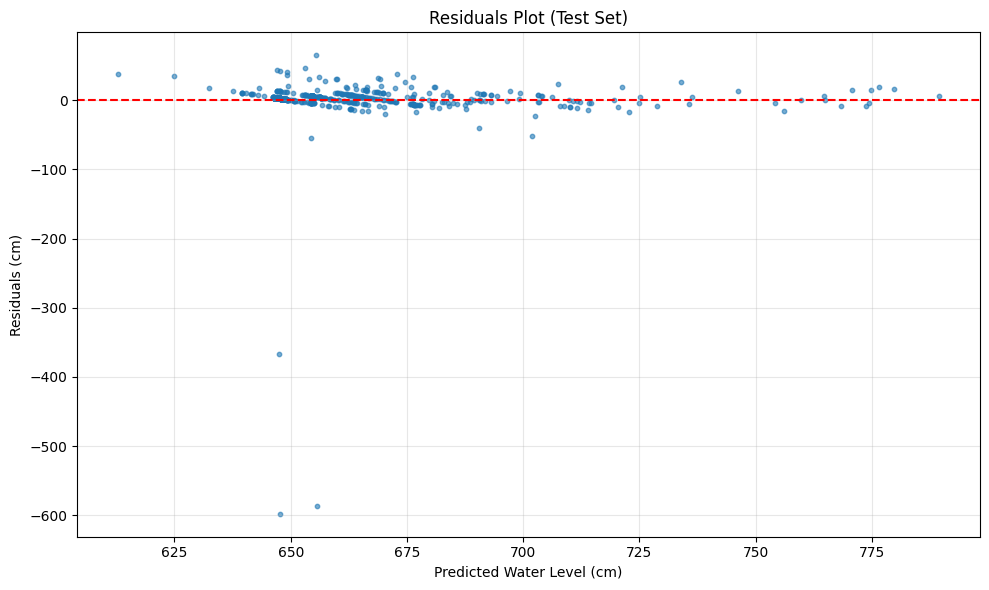

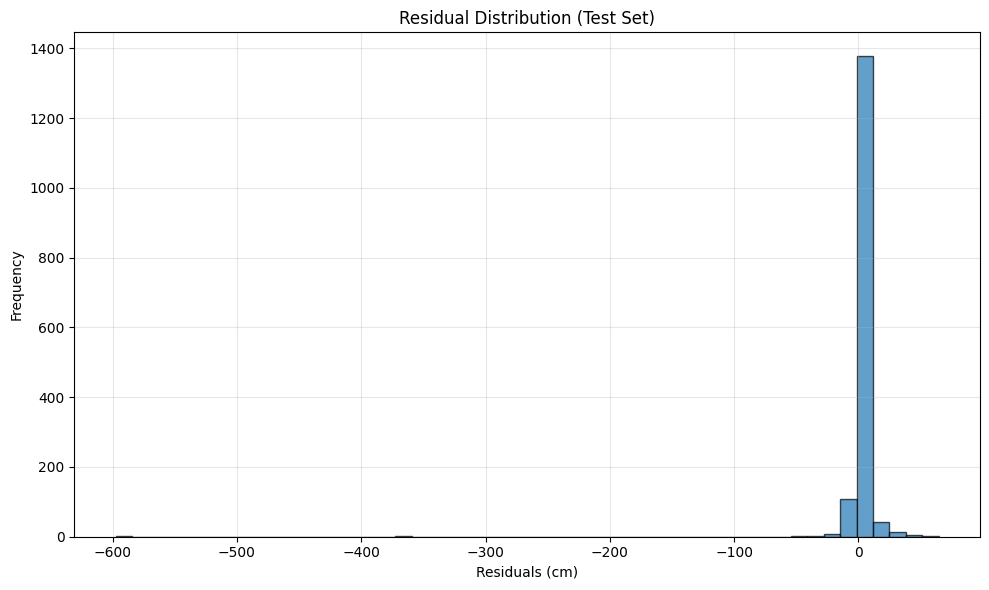

In [10]:
# =============================================================================
# PLOT 1: Training Validation Curve
# =============================================================================

plt.figure(figsize=(10, 6))
eval_results = model.evals_result()
if 'validation_0' in eval_results:
    plt.plot(eval_results['validation_0']['rmse'], label='Validation RMSE', alpha=0.8)
    plt.axvline(x=model.best_iteration, color='red', linestyle='--', label='Best Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Validation RMSE During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Training progress\nnot available',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Training Progress')

plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 2: Actual vs Predicted (Test Set)
# =============================================================================

plt.figure(figsize=(10, 8))
plt.scatter(y_test, test_pred, alpha=0.6, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water Level (cm)')
plt.ylabel('Predicted Water Level (cm)')
plt.title(f'Actual vs Predicted (Test Set)\nR² = {test_r2:.4f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 3: Time Series Prediction (Last 500 Points)
# =============================================================================

plt.figure(figsize=(12, 6))
plot_points = min(500, len(y_test))
plt.plot(y_test.tail(plot_points), label='Actual', linewidth=1.5, alpha=0.8)
plt.plot(y_test.tail(plot_points).index, test_pred[-plot_points:],
         label='Predicted', linewidth=1.5, alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Water Level (cm)')
plt.title(f'Time Series Prediction (Last {plot_points} Hours)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 4: Residuals Plot
# =============================================================================

plt.figure(figsize=(10, 6))
plt.scatter(test_pred, residuals_test, alpha=0.6, s=10)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Water Level (cm)')
plt.ylabel('Residuals (cm)')
plt.title('Residuals Plot (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 5: Residuals Histogram
# =============================================================================

plt.figure(figsize=(10, 6))
plt.hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals (cm)')
plt.ylabel('Frequency')
plt.title('Residual Distribution (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
features_to_remove = [
    'manggarai_cuaca_hujan',
    'time_index'
]
X_train.drop(columns=features_to_remove, inplace=True, errors='ignore')
X_test.drop(columns=features_to_remove, inplace=True, errors='ignore')

# Baseline Model of the Grid Search

In [12]:
fixed_params = {
    'tree_method': 'gpu_hist',
    'gpu_id': 0,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 1,
}

In [14]:
baseline_start = datetime.now()
baseline_model = xgb.XGBRegressor(**fixed_params)
baseline_model.fit(X_train, y_train)
baseline_time = datetime.now() - baseline_start

baseline_train_pred = baseline_model.predict(X_train)
baseline_test_pred = baseline_model.predict(X_test)

# Calculate metrics for training set
baseline_train_rmse = np.sqrt(mean_squared_error(y_train, baseline_train_pred))
baseline_train_mae = mean_absolute_error(y_train, baseline_train_pred)
baseline_train_r2 = r2_score(y_train, baseline_train_pred)
baseline_train_mape = mean_absolute_percentage_error(y_train, baseline_train_pred)

# Calculate metrics for test set
baseline_test_rmse = np.sqrt(mean_squared_error(y_test, baseline_test_pred))
baseline_test_mae = mean_absolute_error(y_test, baseline_test_pred)
baseline_test_r2 = r2_score(y_test, baseline_test_pred)
baseline_test_mape = mean_absolute_percentage_error(y_test, baseline_test_pred)

print(f"Baseline completed in {baseline_time}")

print(f"Baseline Train RMSE: {baseline_train_rmse:.4f}")
print(f"Baseline Train MAE: {baseline_train_mae:.4f}")
print(f"Baseline Train R2: {baseline_train_r2:.4f}")
print(f"Baseline Train MAPE: {baseline_train_mape:.4f}")

print(f"Baseline Test RMSE: {baseline_test_rmse:.4f}")
print(f"Baseline Test MAE: {baseline_test_mae:.4f}")
print(f"Baseline Test R2: {baseline_test_r2:.4f}")
print(f"Baseline Test MAPE: {baseline_test_mape:.4f}")

Baseline completed in 0:00:00.218923
Baseline Train RMSE: 11.4139
Baseline Train MAE: 3.0615
Baseline Train R2: 0.9368
Baseline Train MAPE: 0.0090
Baseline Test RMSE: 24.5460
Baseline Test MAE: 4.5129
Baseline Test R2: 0.2800
Baseline Test MAPE: 0.0192


# Grid Search

In [ ]:
print(f"\n{datetime.now().strftime('%H:%M:%S')} - Starting coarse grid search...")

In [23]:
param_grid = {
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [300, 500],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.5, 1.0]
}

In [24]:
combinations = 1
for param, values in param_grid.items():
    combinations *= len(values)
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {combinations}")

  max_depth: [4, 6, 8]
  min_child_weight: [1, 3]
  subsample: [0.8, 1.0]
  colsample_bytree: [0.8, 1.0]
  learning_rate: [0.05, 0.1, 0.15]
  n_estimators: [300, 500]
  reg_alpha: [0.1, 0.5]
  reg_lambda: [0.5, 1.0]

Total combinations: 576


In [25]:
# Run grid search
base_model = xgb.XGBRegressor(**fixed_params)
grid_start = datetime.now()

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=2
)

grid_search.fit(X_train, y_train)
grid_time = datetime.now() - grid_start

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300,

In [26]:
print(f"Grid search time: {grid_time}")
print(f"Best grid CV score: {-grid_search.best_score_:.4f}")
print(f"Best grid parameters: {grid_search.best_params_}")

Grid search time: 0:22:28.614642
Best grid CV score: 16.8175
Best grid parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8}


In [27]:
grid_results_df = pd.DataFrame(grid_search.cv_results_)
grid_results_df.to_csv('08 grid_search_results.csv', index=False)

# Final Parameter

In [28]:
final_params = {**fixed_params, **grid_search.best_params_, 'early_stopping_rounds': 50}

print("Final parameters:")
for key, value in final_params.items():
    print(f"  {key}: {value}")

Final parameters:
  tree_method: gpu_hist
  gpu_id: 0
  objective: reg:squarederror
  eval_metric: rmse
  random_state: 42
  n_jobs: -1
  verbosity: 1
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 4
  min_child_weight: 3
  n_estimators: 300
  reg_alpha: 0.5
  reg_lambda: 1.0
  subsample: 0.8
  early_stopping_rounds: 50


In [29]:
# Train final model
final_start = datetime.now()
final_model = xgb.XGBRegressor(**final_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
final_training_time = datetime.now() - final_start

print(f"\nTraining completed in: {training_time}")
print(f"Best iteration: {model.best_iteration}")
print(f"Best score: {model.best_score:.4f}")


Training completed in: 0:00:00.826444
Best iteration: 27
Best score: 24.1459


In [30]:
# Make predictions
train_pred = final_model.predict(X_train)
test_pred = final_model.predict(X_test)

# Calculate metrics for training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)

# Calculate metrics for test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)

print("TRAINING SET METRICS:")
print(f"  RMSE: {train_rmse:.4f} cm")
print(f"  MAE:  {train_mae:.4f} cm")
print(f"  R²:   {train_r2:.4f}")
print(f"  MAPE: {train_mape:.2f}%")

print("\nTEST SET METRICS:")
print(f"  RMSE: {test_rmse:.4f} cm")
print(f"  MAE:  {test_mae:.4f} cm")
print(f"  R²:   {test_r2:.4f}")
print(f"  MAPE: {test_mape:.2f}%")

TRAINING SET METRICS:
  RMSE: 16.5171 cm
  MAE:  4.9175 cm
  R²:   0.8676
  MAPE: 0.02%

TEST SET METRICS:
  RMSE: 24.1184 cm
  MAE:  5.3663 cm
  R²:   0.3049
  MAPE: 0.02%


In [31]:
final_model.save_model('final_optimized_xgboost_model.json')

In [32]:
# Calculate additional metrics
residuals_test = y_test - test_pred
print(f"\nADDITIONAL TEST METRICS:")
print(f"  Mean Residual: {np.mean(residuals_test):.4f} cm")
print(f"  Std Residual:  {np.std(residuals_test):.4f} cm")
print(f"  Max Error:     {np.max(np.abs(residuals_test)):.4f} cm")


ADDITIONAL TEST METRICS:
  Mean Residual: 1.5120 cm
  Std Residual:  24.0709 cm
  Max Error:     597.6706 cm


Most Important Features:
                    feature  importance
         manggarai_air_lag1    0.422886
         manggarai_air_lag2    0.319284
         manggarai_air_lag4    0.043973
         manggarai_air_lag3    0.040383
             depok_air_lag7    0.040309
             depok_air_lag8    0.022311
 manggarai_cuaca_lag5_hujan    0.017263
             depok_air_lag6    0.014524
         manggarai_air_lag5    0.013727
         manggarai_air_lag6    0.009197
 manggarai_cuaca_lag1_hujan    0.007032
             depok_air_lag9    0.006905
        katulampa_air_lag11    0.005637
     depok_cuaca_lag7_hujan    0.005247
                   hour_cos    0.005061
 manggarai_cuaca_lag4_hujan    0.005007
     depok_cuaca_lag6_hujan    0.004882
katulampa_cuaca_lag12_hujan    0.003284
                   hour_sin    0.002688
 manggarai_cuaca_lag3_hujan    0.002343
        katulampa_air_lag13    0.002198
 manggarai_cuaca_lag2_hujan    0.002086
        katulampa_air_lag12    0.001893
katulampa_cuaca

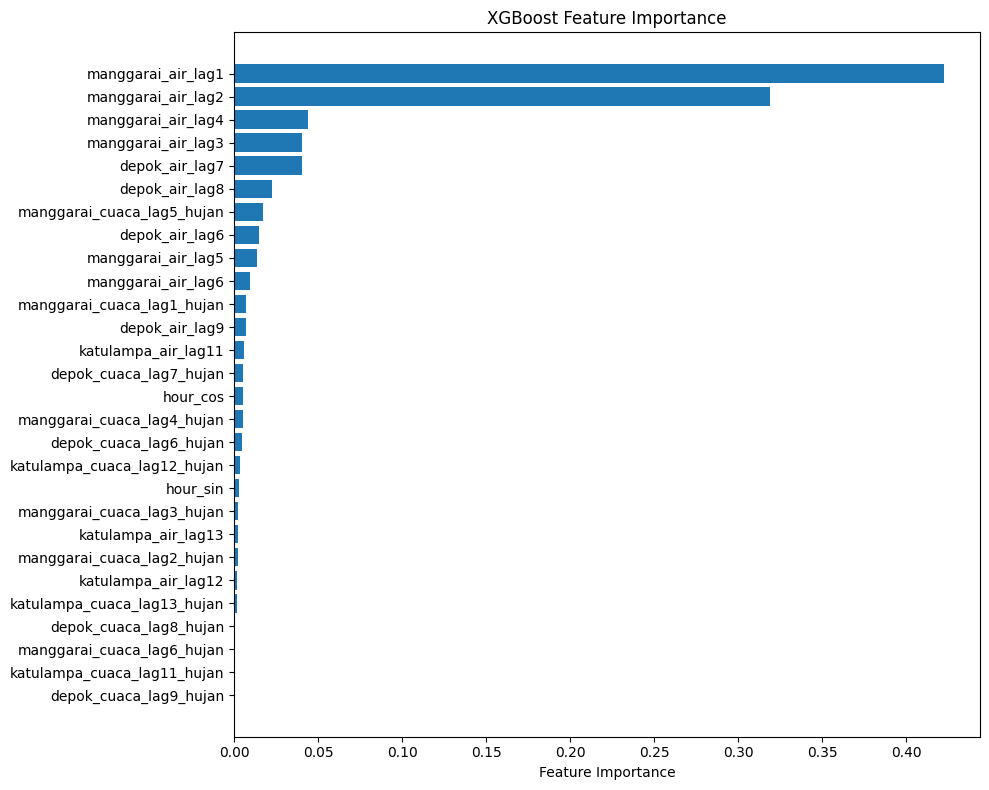

In [35]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Most Important Features:")
print(feature_importance.to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

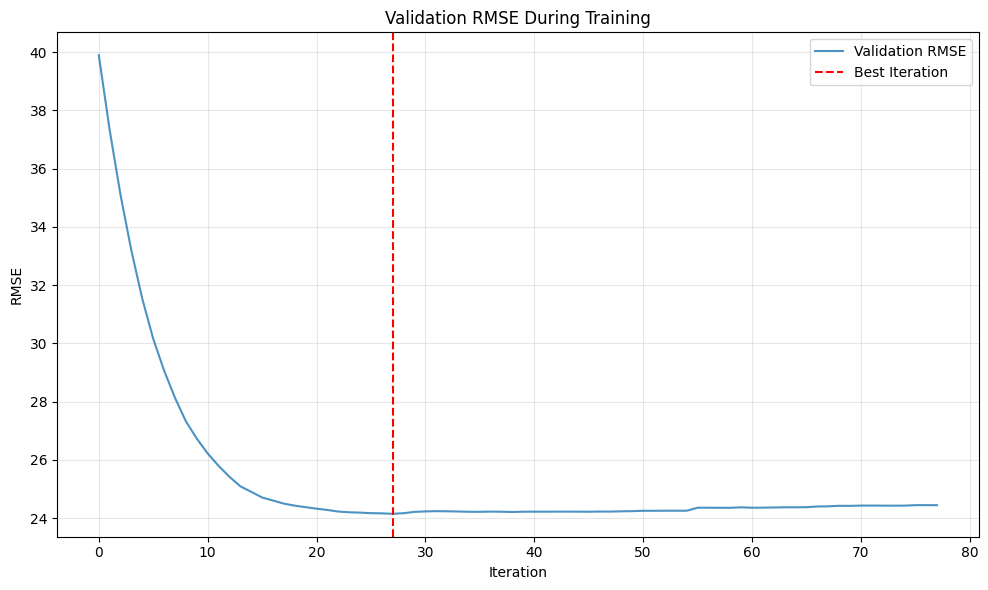

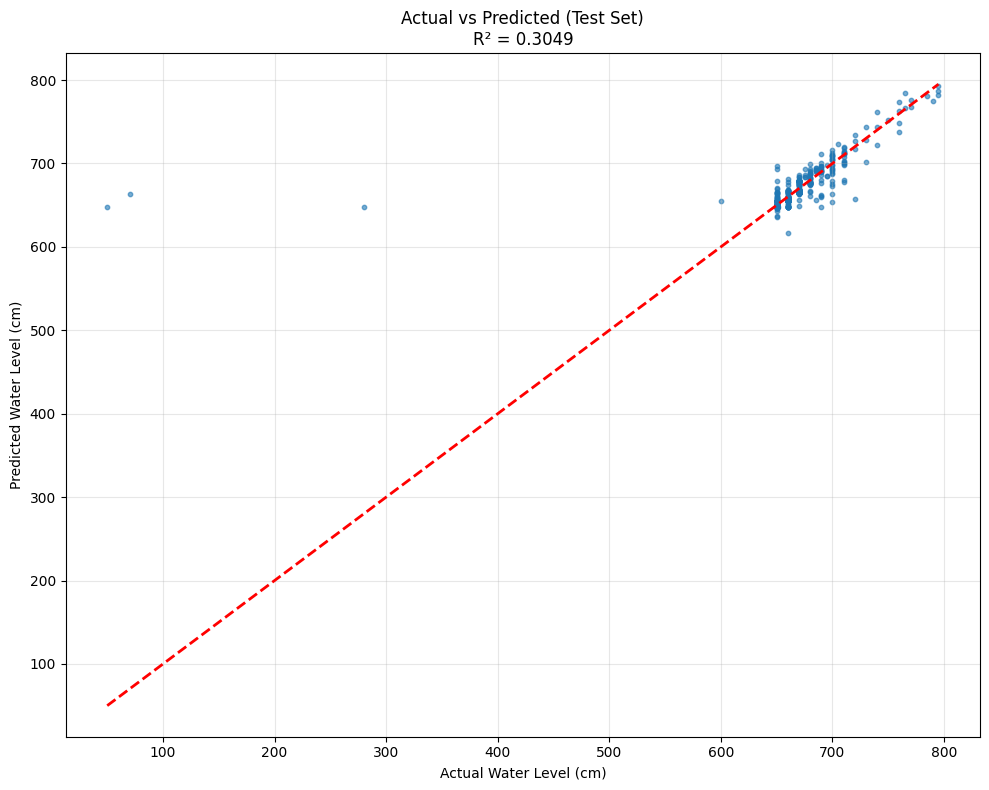

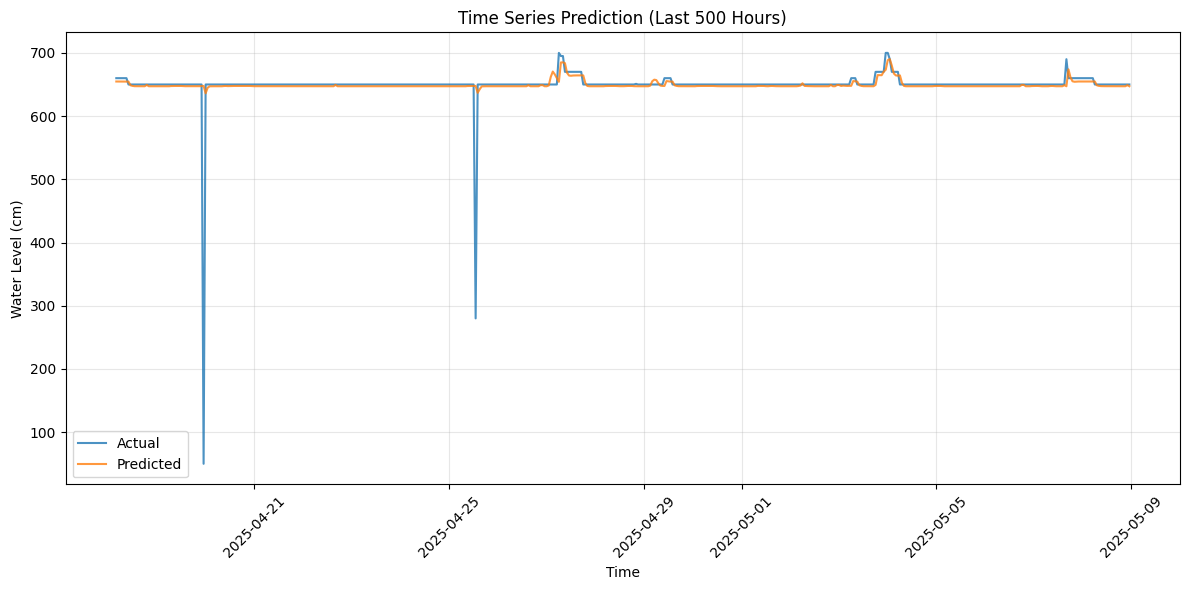

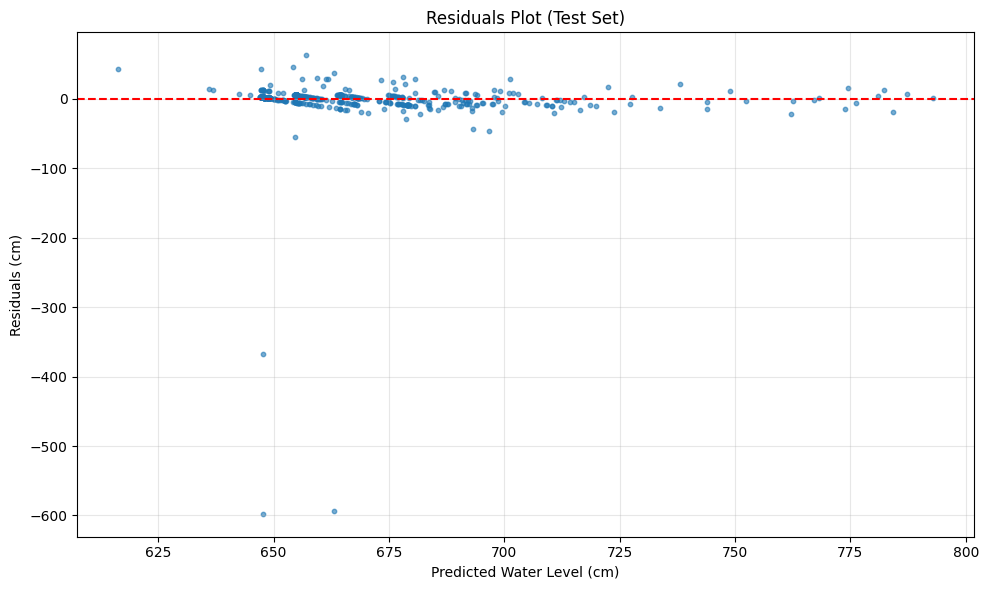

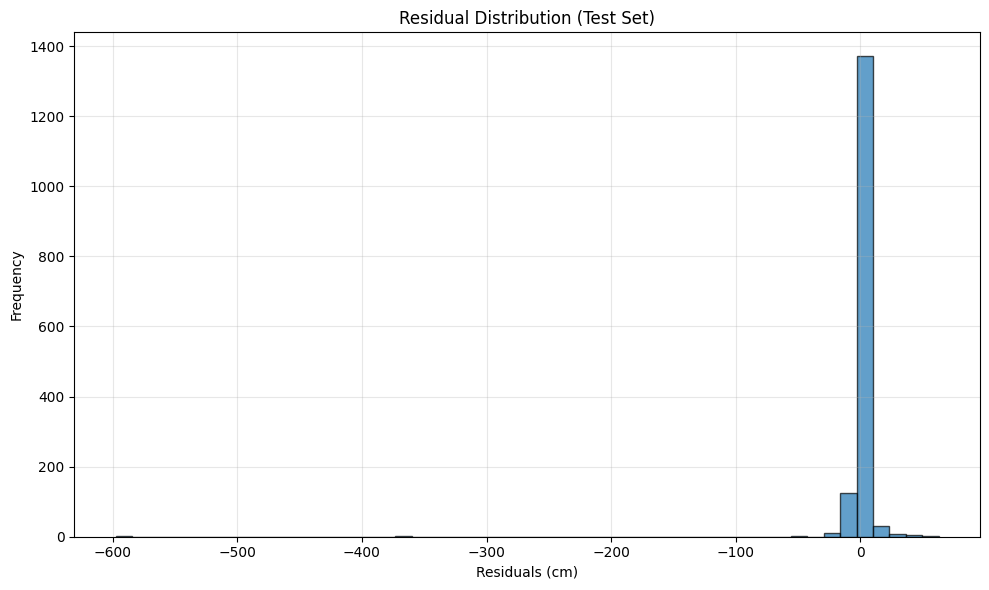

In [36]:
# =============================================================================
# PLOT 1: Training Validation Curve
# =============================================================================

plt.figure(figsize=(10, 6))
eval_results = model.evals_result()
if 'validation_0' in eval_results:
    plt.plot(eval_results['validation_0']['rmse'], label='Validation RMSE', alpha=0.8)
    plt.axvline(x=model.best_iteration, color='red', linestyle='--', label='Best Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Validation RMSE During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Training progress\nnot available',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Training Progress')

plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 2: Actual vs Predicted (Test Set)
# =============================================================================

plt.figure(figsize=(10, 8))
plt.scatter(y_test, test_pred, alpha=0.6, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water Level (cm)')
plt.ylabel('Predicted Water Level (cm)')
plt.title(f'Actual vs Predicted (Test Set)\nR² = {test_r2:.4f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 3: Time Series Prediction (Last 500 Points)
# =============================================================================

plt.figure(figsize=(12, 6))
plot_points = min(500, len(y_test))
plt.plot(y_test.tail(plot_points), label='Actual', linewidth=1.5, alpha=0.8)
plt.plot(y_test.tail(plot_points).index, test_pred[-plot_points:],
         label='Predicted', linewidth=1.5, alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Water Level (cm)')
plt.title(f'Time Series Prediction (Last {plot_points} Hours)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 4: Residuals Plot
# =============================================================================

plt.figure(figsize=(10, 6))
plt.scatter(test_pred, residuals_test, alpha=0.6, s=10)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Water Level (cm)')
plt.ylabel('Residuals (cm)')
plt.title('Residuals Plot (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 5: Residuals Histogram
# =============================================================================

plt.figure(figsize=(10, 6))
plt.hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals (cm)')
plt.ylabel('Frequency')
plt.title('Residual Distribution (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
